# 11_PLS_find_metagene

In [1]:
import os
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as clr
color_self = clr.LinearSegmentedColormap.from_list('pink_green', ['#3AB370',"#EAE7CC","#FD1593"], N=256)
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
from sklearn.cross_decomposition import PLSRegression
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
cluster_colors=['#4b6aa8','#3ca0cf','#c376a7','#ad98c3','#408444',
                '#53738c','#a25087','#a78982','#a9c2cb','#92699e',
                '#d69971','#df5734','#6c408e','#ac6894','#d4c2db',
                '#537eb7','#83ab8e','#ece399','#405993','#cc7f73',
                '#b95055','#d5bb72','#bc9a7f','#e0cfda','#d8a0c0',
                '#e6b884','#b05545','#d69a55','#64a776','#cbdaa9',
                '#efd2c9','#da6f6d','#ebb1a4','#a44e89','#8c564b',
                '#b85292','#6d6fa0','#8d689d','#c8c7e1','#d25774',
                '#c49abc','#a5a9b0','#927c9a','#9f8d89','#72567a',
                '#63a3b8','#c4daec','#61bada','#b7deea','#e29eaf',
                '#4490c4','#e6e2a3','#de8b36','#c4612f','#9a70a8',
                '#76a2be','#cea5c7','#c6adb0','#9d3b62','#2d3462', 
                '#FF420E','#FFBB00']

In [3]:
path = './results/mouse_1/2024_04_08_20_10_00GATE_2encoder_cat_feature_decoder_skip_connect_bn/'
adata = sc.read_h5ad(path + 'feature_add_weight1/Clusters_res0.75/adata_cluster_feature.h5ad')
allen_region = pd.read_csv('/mnt/Data16Tc/home/haichao/code/SpaCon/ST_NT_cluster/SpaCon_apply_zxw/data/mouse_1/allen_region.csv')
adata.obs['region'] = allen_region['region'].to_list()
adata

AnnData object with n_obs × n_vars = 250535 × 1122
    obs: 'x_section_mean', 'x', 'y', 'z', 'section', 'NT_index', 'Cells_id', 'clusters', 'region'
    var: 'gene_identifier', 'name', 'mapped_ncbi_identifier'
    uns: 'clusters_colors', 'log1p', 'louvain', 'neighbors', 'umap'
    obsm: 'GATE_feature_add', 'GATE_feature_con', 'GATE_feature_spa', 'X_umap'
    obsp: 'connectivities', 'distances'

In [4]:
adata.obsm['spatial'] = adata.obs[['z', 'y']].values

### PLS

#### th gene

In [5]:
adata = adata[adata.obs['z'] < 56]

In [126]:
cluster = '11'
sec = 'Zhuang-ABCA-1.093'

In [127]:
th_regions = ['AD', 'AMd', 'AMv', 'AV', 'CL', 'CM', 'IAD', 'IAM', 'IGL', 'IMD', 'LD', 'LGv', 'LH', 'LP', 'MD', 'MGd', 'MGm', 'MGv', 'MH', 'PCN', 'PF', 'PIL', 'PO', 'POL',
                'PP', 'PR', 'PT', 'PVT', 'PoT', 'RE', 'RH', 'RT', 'SGN', 'SMT', 'SPA', 'SPFm', 'SPFp', 'VAL', 'VM', 'VPL', 'VPLpc', 'VPM', 'VPMpc', 'Xi']
adata.obs['th_cluster'] = adata.obs['clusters'].astype(str)
adata.obs.loc[~(adata.obs['region'].isin(th_regions)), 'th_cluster'] = '-1'
# adata.obs

In [128]:
# 2. Prepare data
X = adata.X.A  # Gene expression matrix
y = adata.obs['th_cluster'].values  # Category

# Convert the category label to a dual classification problem.
y_binary = np.where(y == cluster, 1, 0)

# 4. Create a PLS model
pls = PLSRegression(n_components=10)
pls.fit(X, y_binary)

# 5. Analytical results
coefficients = pls.coef_.flatten()
# coefficients = np.abs(pls.coef_.ravel())

gene_names = adata.var_names
th_gene_importance = pd.DataFrame({
    'Gene': gene_names,
    'Coefficient': coefficients,
    'Importance': np.abs(coefficients)
})

In [129]:
# The average value and standard deviation of the importance of calculation
importance_mean = th_gene_importance['Importance'].mean()
importance_std = th_gene_importance['Importance'].std()

# Selection importance is higher than the genetic gene
th_genes = th_gene_importance.sort_values(by='Importance', ascending=False).head(30)
# Sort by the importance of importance
th_genes = th_genes.sort_values('Importance', ascending=False)
# Only using the selected genes to re -calculate the weighted expression
X_selected = X[:, [list(gene_names).index(gene) for gene in th_genes['Gene']]]
coefficients_selected = th_genes['Coefficient'].values
weighted_expression = np.dot(X_selected, coefficients_selected)
# Add the weighted expression vector to the original data
scaler = StandardScaler()
adata.obs['th_Expression'] = scaler.fit_transform(weighted_expression.reshape(-1, 1))
# th_genes.to_csv(f'./th_ctx_cluster_gene/cluster{cluster}_th_gene.csv')
th_genes

Gene  Coefficient  Importance
566      Gbx2     0.003416    0.003416
1002    Tnnt1     0.002547    0.002547
316     Rgs16     0.002258    0.002258
72    Grid2ip     0.002062    0.002062
318     Cnih3    -0.001923    0.001923
1079  Abhd12b    -0.001762    0.001762
73      Vipr2     0.001742    0.001742
1007  Plekhd1     0.001628    0.001628
199     Prkcd     0.001527    0.001527
495     Cbln1    -0.001472    0.001472
699       Tox     0.001430    0.001430
720      Pkp2     0.001408    0.001408
36      Calb2     0.001397    0.001397
388     Calb1     0.001376    0.001376
694     Ramp3     0.001354    0.001354
1016      Sp9     0.001315    0.001315
459     Rab38     0.001273    0.001273
3       Glra1    -0.001234    0.001234
21      Grik3     0.001228    0.001228
800      Arsj     0.001199    0.001199
922     Nell1     0.001121    0.001121
220     Endou     0.001112    0.001112
252   Galnt14    -0.001100    0.001100
1084  Tcerg1l     0.001084    0.001084
727    Adora1     0.001072    0.001072
414     Ptpru     0.001062    0.001062
676      Ldb2     0.001031    0.001031
60      Itih3     0.001020    0.001020
505       Agt     0.001004    0.001004
871     Trhde     0.000991    0.000991

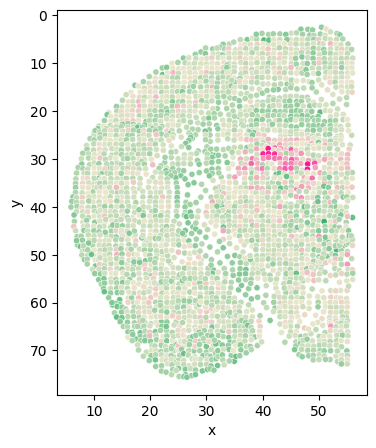

In [109]:
# sec = 'Zhuang-ABCA-1.089'
adata_s = adata[adata.obs['section'] == sec]
# fig, ax = plt.subplots(figsize=(4, 5))
# sc.pl.spatial(adata_s, color=['th_Expression'], spot_size=1, cmap=color_self, ax=ax)

df = pd.DataFrame({
    'x': adata_s.obs['z'],
    'y': adata_s.obs['y'],
    # 'expression': adata_s[:, 'Zfhx4'].layers['adj_gene'].A.flatten()  # Showping is a one -dimensional array
    'expression': adata_s.obs['th_Expression'] 
})
# Create a scattered point picture
plt.figure(figsize=(4, 5))  # Adjust to the required image size
scatter_plot = sns.scatterplot(data=df, x='x', y='y', hue='expression', palette=color_self, s=20, legend=False) 
plt.gca().invert_yaxis()
# scatter_plot.set_title('Gene Expression Spatial Plot')

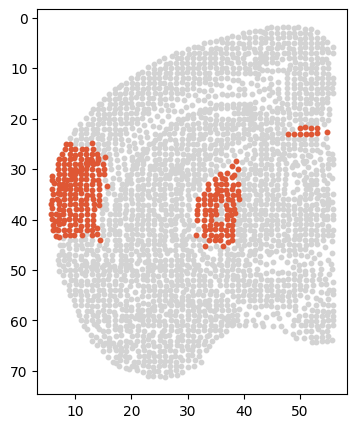

In [44]:
# Class_i = '34'
# section = 'Zhuang-ABCA-1.087'
cluster_i_section_i_adata = adata[(adata.obs['clusters'] == cluster) & (adata.obs['section'] == sec)]
cluster_i_section_i_adata = cluster_i_section_i_adata[cluster_i_section_i_adata.obs['z'] < 56]

back = adata[adata.obs['section'] == sec]
# back = back[back.obs['z'] < 56]

fig = plt.figure(figsize=(4, 5))
plt.scatter(back.obs['z'], back.obs['y'], s=10, c='#D3D3D3')
plt.scatter(cluster_i_section_i_adata.obs['z'], cluster_i_section_i_adata.obs['y'], s=10, c=cluster_colors[int(cluster)])
plt.gca().invert_yaxis()

#### ctx gene

In [130]:
ctx_regions = ['ACAd', 'ACAv', 'AId', 'AIp', 'AIv', 'AUDd', 'AUDp', 'AUDpo',
                'AUDv', 'ECT', 'FRP', 'GU', 'ILA', 'MOp', 'MOs', 'ORBl', 'ORBm',
                'ORBvl', 'PERI', 'PL', 'RSPagl', 'RSPd', 'RSPv', 'SSp-bfd',
                'SSp-ll', 'SSp-m', 'SSp-n', 'SSp-tr', 'SSp-ul', 'SSp-un', 'SSs',
                'TEa', 'VISC', 'VISa', 'VISal', 'VISam', 'VISl', 'VISli', 'VISp',
                'VISpl', 'VISpm', 'VISpor', 'VISrl']
adata.obs['ctx_cluster'] = adata.obs['clusters'].astype(str)
adata.obs.loc[~(adata.obs['region'].str.startswith(tuple(ctx_regions))), 'ctx_cluster'] = '-1'
# adata.obs

In [131]:
# 2. Prepare data
X = adata.X.A  # Gene expression matrix
y = adata.obs['ctx_cluster'].values  # Category

# Convert the category label to a dual classification problem.
y_binary = np.where(y == cluster, 1, 0)

# 4. Create a PLS model
pls = PLSRegression(n_components=10) 

# 5. Analytical results
coefficients = pls.coef_.flatten()
# coefficients = np.abs(pls.coef_.ravel())

gene_names = adata.var_names
ctx_gene_importance = pd.DataFrame({
    'Gene': gene_names,
    'Coefficient': coefficients,
    'Importance': np.abs(coefficients)
})

In [132]:
# The average value and standard deviation of calculation importance
importance_mean = ctx_gene_importance['Importance'].mean()
importance_std = ctx_gene_importance['Importance'].std()
# Set the threshold to the average value plus a standard deviation

# Selection importance is higher than the genetic gene
ctx_genes =  ctx_gene_importance.sort_values(by='Importance', ascending=False).head(30)
# Sort by importance
ctx_genes = ctx_genes.sort_values('Importance', ascending=False)

# Use the selected genes to re -calculate the weighted expression
X_selected = X[:, [list(gene_names).index(gene) for gene in ctx_genes['Gene']]]
coefficients_selected = ctx_genes['Coefficient'].values
weighted_expression = np.dot(X_selected, coefficients_selected)
# Add the weighted expression vector to the original data
scaler = StandardScaler()
adata.obs['ctx_Expression'] = X_scaled = scaler.fit_transform(weighted_expression.reshape(-1, 1))
# ctx_genes.to_csv(f'./th_ctx_cluster_gene/cluster{cluster}_ctx_gene.csv')
ctx_genes

Gene  Coefficient  Importance
334     Nr4a2     0.009431    0.009431
886     Igfn1    -0.007870    0.007870
1053     Rprm     0.006268    0.006268
929     Synpr     0.006225    0.006225
1015    Gpr88     0.005867    0.005867
1040    Kcng1    -0.005755    0.005755
818    Ankfn1     0.005611    0.005611
308     Lypd1     0.005590    0.005590
385    Adgrl2    -0.005482    0.005482
63       Tcap     0.005284    0.005284
66        Met     0.005279    0.005279
673      Cdh6     0.005004    0.005004
775      Penk    -0.004897    0.004897
347     Meis2    -0.004787    0.004787
182    Cartpt     0.004753    0.004753
156      Coch     0.004689    0.004689
649     Satb2     0.004687    0.004687
352    Adam33    -0.004262    0.004262
996    Egfem1     0.004241    0.004241
626      Ccn3     0.004161    0.004161
268     Cbln2    -0.004144    0.004144
761    Zbtb7c     0.004122    0.004122
261       Grp     0.004041    0.004041
942      Lepr     0.004033    0.004033
507     Trpc6    -0.004007    0.004007
840     Efna5     0.003998    0.003998
280   Bhlhe22     0.003956    0.003956
386   Col24a1     0.003950    0.003950
292     Oprk1     0.003938    0.003938
744     Mdga1     0.003865    0.003865

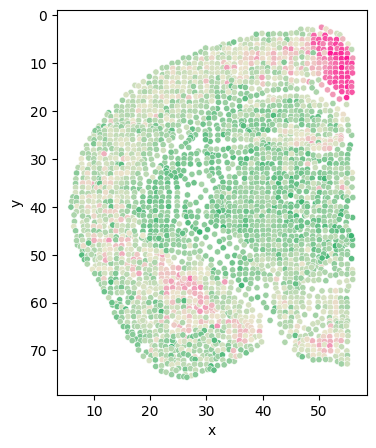

In [113]:
# sec =  'Zhuang-ABCA-1.089'
adata_s = adata[adata.obs['section'] == sec]
# fig, ax = plt.subplots(figsize=(4, 5))
# sc.pl.spatial(adata_s, color=['ctx_Expression'], spot_size=1, cmap=color_self, ax=ax)

df = pd.DataFrame({
    'x': adata_s.obs['z'],
    'y': adata_s.obs['y'],
    # 'expression': adata_s[:, 'Zfhx4'].layers['adj_gene'].A.flatten() 
    'expression': adata_s.obs['ctx_Expression'] 
})
plt.figure(figsize=(4, 5)) 
scatter_plot = sns.scatterplot(data=df, x='x', y='y', hue='expression', palette=color_self, s=20, legend=False) 
plt.gca().invert_yaxis()
# scatter_plot.set_title('Gene Expression Spatial Plot')

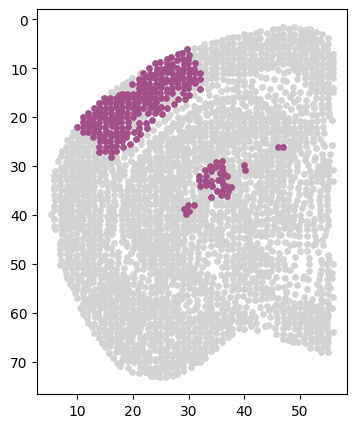

In [204]:
# Class_i = '34'
# section = 'Zhuang-ABCA-1.087'
cluster_i_section_i_adata = adata[(adata.obs['clusters'] == cluster) & (adata.obs['section'] == sec)]
cluster_i_section_i_adata = cluster_i_section_i_adata[cluster_i_section_i_adata.obs['z'] < 56]

back = adata[adata.obs['section'] == sec]
back = back[back.obs['z'] < 56]

fig = plt.figure(figsize=(4, 5))
plt.scatter(back.obs['z'], back.obs['y'], s=15, c='#D3D3D3')
plt.scatter(cluster_i_section_i_adata.obs['z'], cluster_i_section_i_adata.obs['y'], s=15, c=cluster_colors[int(cluster)])
plt.gca().invert_yaxis()

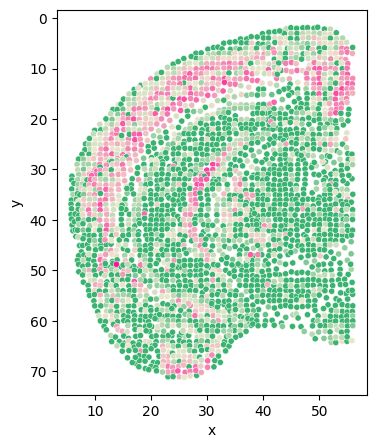

In [136]:
adata.obs['ctx_th_Expression'] = adata.obs['ctx_Expression'] + adata.obs['th_Expression']
adata_s = adata[adata.obs['section'] == sec]
df = pd.DataFrame({
    'x': adata_s.obs['z'],
    'y': adata_s.obs['y'],
    'expression': adata_s[:, 'Trhde'].X.A.flatten()
    # 'expression': adata_s[:, 'Zfhx4'].layers['adj_gene'].A.flatten()  
    # 'expression': adata_s.obs['ctx_th_Expression']  
})

plt.figure(figsize=(4, 5)) 
scatter_plot = sns.scatterplot(data=df, x='x', y='y', hue='expression', palette=color_self, s=20, legend=False)  
plt.gca().invert_yaxis()

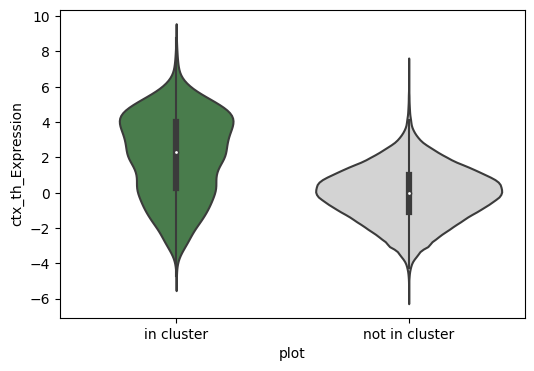

In [115]:
tmp_df = adata.obs[['ctx_th_Expression', 'clusters']]
tmp_df['plot'] = 'not in cluster'
tmp_df.loc[tmp_df['clusters'] == cluster, 'plot'] = 'in cluster'

means = tmp_df.groupby('plot')['ctx_th_Expression'].mean()
plt.figure(figsize=(6, 4))
sns.violinplot(data=tmp_df, x='plot', y='ctx_th_Expression', 
               palette=[cluster_colors[int(cluster)], '#d3d3d3'],order=['in cluster', 'not in cluster'])
plt.savefig(f'./th_ctx_cluster_gene/cluster{cluster}.pdf', format = 'pdf')

#### other regions

In [117]:
cluster = '13'
sec = 'Zhuang-ABCA-1.099'

In [118]:
# 2. Prepare data
X = adata.X.A  # Gene expression matrix
y = adata.obs['clusters'].values  # Category

# Convert the category label to a dual classification problem.
y_binary = np.where(y == cluster, 1, 0)

# 4. Create a PLS model
pls = PLSRegression(n_components=10) 
pls.fit(X, y_binary)

coefficients = pls.coef_.flatten()

gene_names = adata.var_names
ctx_gene_importance = pd.DataFrame({
    'Gene': gene_names,
    'Coefficient': coefficients,
    'Importance': np.abs(coefficients)
})

In [119]:
# The average value and standard deviation of calculation importance
importance_mean = ctx_gene_importance['Importance'].mean()
importance_std = ctx_gene_importance['Importance'].std()

# Selection importance is higher than the genetic gene
ctx_genes =  ctx_gene_importance.sort_values(by='Importance', ascending=False).head(30)
# Sort by importance
ctx_genes = ctx_genes.sort_values('Importance', ascending=False)

# Use the selected genes to re -calculate the weighted expression
X_selected = X[:, [list(gene_names).index(gene) for gene in ctx_genes['Gene']]]
coefficients_selected = ctx_genes['Coefficient'].values
weighted_expression = np.dot(X_selected, coefficients_selected)
# Add the weighted expression vector to the original data
scaler = StandardScaler()
adata.obs['other_Expression'] = X_scaled = scaler.fit_transform(weighted_expression.reshape(-1, 1))
len(ctx_genes)

30

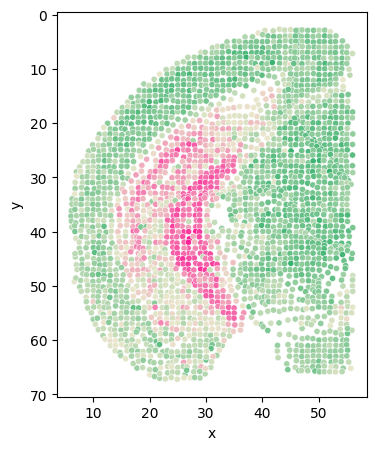

In [120]:
# sec =  'Zhuang-ABCA-1.113'
adata_s = adata[adata.obs['section'] == sec]
# fig, ax = plt.subplots(figsize=(4, 5))
# sc.pl.spatial(adata_s, color=['other_Expression'], spot_size=1, cmap=color_self, ax=ax)

df = pd.DataFrame({
    'x': adata_s.obs['z'],
    'y': adata_s.obs['y'],
    # 'expression': adata_s[:, 'Zfhx4'].layers['adj_gene'].A.flatten() 
    'expression': adata_s.obs['other_Expression']
})
# 创建散点图
plt.figure(figsize=(4, 5))  # 调整为所需的图像大小
scatter_plot = sns.scatterplot(data=df, x='x', y='y', hue='expression', palette=color_self, s=20, legend=False) 
plt.gca().invert_yaxis()
# scatter_plot.set_title('Gene Expression Spatial Plot')

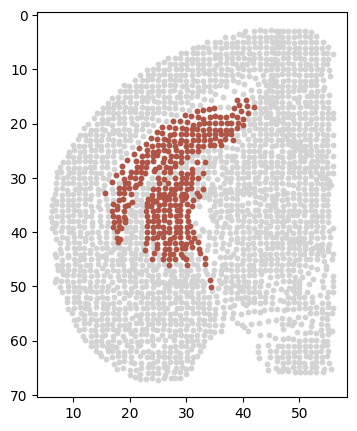

In [127]:
# Class_i = '34'
# section = 'Zhuang-ABCA-1.087'
cluster_i_section_i_adata = adata[(adata.obs['clusters'] == cluster) & (adata.obs['section'] == sec)]
cluster_i_section_i_adata = cluster_i_section_i_adata[cluster_i_section_i_adata.obs['z'] < 56]

back = adata[adata.obs['section'] == sec]
back = back[back.obs['z'] < 56]

fig = plt.figure(figsize=(4, 5))
plt.scatter(back.obs['z'], back.obs['y'], s=10, c='#D3D3D3')
plt.scatter(cluster_i_section_i_adata.obs['z'], cluster_i_section_i_adata.obs['y'], s=10, c=cluster_colors[int(cluster)+13])
plt.gca().invert_yaxis()